In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

def load_cifar10(path):

    with open(path, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

train_data_1 = load_cifar10('cifar-10-batches-py/data_batch_1')
train_data_2 = load_cifar10('cifar-10-batches-py/data_batch_2')
train_data_3 = load_cifar10('cifar-10-batches-py/data_batch_3')
train_data_4 = load_cifar10('cifar-10-batches-py/data_batch_4')
train_data_5 = load_cifar10('cifar-10-batches-py/data_batch_5')

train_data_data = np.concatenate((train_data_1[b'data'], train_data_2[b'data'], train_data_3[b'data'], train_data_4[b'data'], train_data_5[b'data']), axis = 0)
train_data_labels = np.concatenate((train_data_1[b'labels'], train_data_2[b'labels'], train_data_3[b'labels'], train_data_4[b'labels'], train_data_5[b'labels']), axis = 0)

train_data_data.shape

(50000, 3072)

In [2]:
X_train = np.array(train_data_data, dtype=np.float32) / 255.0
y_train = np.array(train_data_labels, dtype=np.int64)


X_train = X_train.reshape(X_train.shape[0], -1)

test_data = load_cifar10('cifar-10-batches-py/test_batch')
X_test = np.array(test_data[b'data'], dtype=np.float32) / 255.0
y_test = np.array(test_data[b'labels'], dtype=np.int64)


X_test = X_test.reshape(X_test.shape[0], -1)


In [12]:
def fully_connected(X, W, b):
    return X.dot(W) + b

def relu(X):
    return np.maximum(0, X)

def softmax(X):
    exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exp_X / np.sum(exp_X, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    N = y_pred.shape[0]
    log_likelihood = -np.log(y_pred[range(N), y_true])
    loss = np.sum(log_likelihood) / N
    return loss

def compute_accuracy(y_pred, y_true):
    return np.mean(np.argmax(y_pred, axis=1) == y_true)

def backward(X, y_true, W1, b1, W2, b2, hidden_output, y_pred, learning_rate, gamma, V_W1, V_b1, V_W2, V_b2):

    N = X.shape[0]

    dL_dy_pred = y_pred
    dL_dy_pred[range(N), y_true] -= 1
    dL_dy_pred /= N

    dL_dW2 = hidden_output.T.dot(dL_dy_pred)
    dL_db2 = np.sum(dL_dy_pred, axis=0)

    dL_dhidden = dL_dy_pred.dot(W2.T)
    dL_dhidden[hidden_output <= 0] = 0

    dL_dW1 = X.T.dot(dL_dhidden)
    dL_db1 = np.sum(dL_dhidden, axis=0)

    V_W1 = gamma*V_W1 + learning_rate * dL_dW1
    V_b1 = gamma*V_b1 + learning_rate * dL_db1
    V_W2 = gamma*V_W2 + learning_rate * dL_dW2
    V_b2 = gamma*V_b2 + learning_rate * dL_db2


    W1 -= V_W1
    b1 -= V_b1
    W2 -= V_W2
    b2 -= V_b2

    return W1, b1, W2, b2, V_W1, V_b1, V_W2, V_b2

def save_parameters(parameter2save,filename='parameterswithmomentum'):
    with open(filename, 'wb') as file:
        pickle.dump(parameter2save, file)

def load_parameters(filename='parameterswithmomentum'):
    try:
        with open(filename, 'rb') as file:
            return pickle.load(file)
    except FileNotFoundError:
        return None

Epoch 1/15, Loss: 2.1083, Accuracy: 0.2709
Epoch 2/15, Loss: 1.9862, Accuracy: 0.3158
Epoch 3/15, Loss: 1.9239, Accuracy: 0.3434
Epoch 4/15, Loss: 1.8691, Accuracy: 0.3620
Epoch 5/15, Loss: 1.8190, Accuracy: 0.3777
Epoch 6/15, Loss: 1.7813, Accuracy: 0.3912
Epoch 7/15, Loss: 1.7452, Accuracy: 0.4025
Epoch 8/15, Loss: 1.7141, Accuracy: 0.4144
Epoch 9/15, Loss: 1.6875, Accuracy: 0.4246
Epoch 10/15, Loss: 1.6664, Accuracy: 0.4370
Epoch 11/15, Loss: 1.6475, Accuracy: 0.4431
Epoch 12/15, Loss: 1.6300, Accuracy: 0.4535
Epoch 13/15, Loss: 1.6198, Accuracy: 0.4573
Epoch 14/15, Loss: 1.6054, Accuracy: 0.4608
Epoch 15/15, Loss: 1.5969, Accuracy: 0.4654


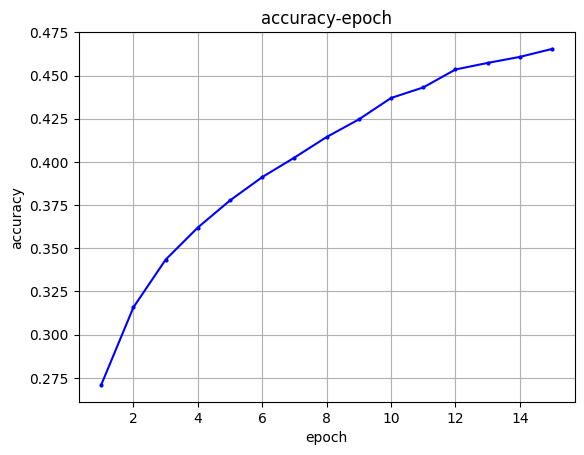

In [14]:

input_dim = 3072
hidden_dim = 100
output_dim = 10

np.random.seed(42)
W1 = 0.01 * np.random.randn(input_dim, hidden_dim)
b1 = np.zeros((1, hidden_dim))
W2 = 0.01 * np.random.randn(hidden_dim, output_dim)
b2 = np.zeros((1, output_dim))


learning_rate = 1e-3
epochs = 15
batch_size = 64
gamma = 0.9
V_W1 = 0
V_b1 = 0
V_W2 = 0
V_b2 = 0

#main

parameters=load_parameters()


if parameters is not None:
    [W1, b1, W2, b2] = parameters
    hidden_output_test = relu(fully_connected(X_test, W1, b1))
    y_pred_test = softmax(fully_connected(hidden_output_test, W2, b2))
        
    accuracy = compute_accuracy(y_pred_test, y_test)
    print(f'Accuracy: {accuracy:.4f}')
    print("delete ./parameters and run again to regenerate local parameters")
else:
    accuracy_array = []
    for epoch in range(epochs):
        

        for i in range(0, X_train.shape[0]-16, batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            #forward
            hidden_output = relu(fully_connected(X_batch, W1, b1))
            y_pred = softmax(fully_connected(hidden_output, W2, b2))

            loss = cross_entropy_loss(y_pred, y_batch)
            
            #backward
            W1, b1, W2, b2, V_W1, V_b1, V_W2, V_b2 = backward(X_batch, y_batch, W1, b1, W2, b2, hidden_output, y_pred, learning_rate, gamma, V_W1, V_b1, V_W2, V_b2)

        hidden_output_test = relu(fully_connected(X_test, W1, b1))
        y_pred_test = softmax(fully_connected(hidden_output_test, W2, b2))
        
        accuracy = compute_accuracy(y_pred_test, y_test)

        accuracy_array.append(accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')



    parameters2save = [W1, b1, W2, b2]
    save_parameters(parameters2save)

    x = np.arange(1, epochs+1)
    plt.plot(x, accuracy_array, marker='o', linestyle='-', color='b', markersize=2)
    plt.title('accuracy-epoch')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.show()
